lesson1-rxt50-CA.ipynb -- Code Along of: 

https://github.com/fastai/fastai/blob/master/courses/dl1/lesson1-rxt50.ipynb
        
Reimplementing the dogsvcats classifier in ResNetXt50

## Dogs v Cats super-charged:

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

PATH = "data/dogscats/"
sz = 299
ARCH = resnext50
bs = 8 # if a TitanX is maxing out at 28, I'll give this 870M 8..

In [3]:
tfms = tfms_from_model(ARCH, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4)
learn = ConvLearner.pretrained(ARCH, data, precompute=True, ps=0.5)
# conv_learner.py: class ConvnetBuilder(): ps (float or array of float): dropout parameters
# NOTE: http://forums.fast.ai/t/error-when-trying-to-use-resnext50/7555
# save weights to fastai/fastai/  -- until this is automatic

Just looking at the fastai library [source code](https://github.com/fastai/fastai/blob/master/fastai/conv_learner.py#L124) while the above works:
```
class ConvLearner(Learner):
    def __init__(self, data, models, precompute=False, **kwargs):
        self.precompute = False
        super().__init__(data, models, **kwargs)
        self.crit = F.binary_cross_entropy if data.is_multi else F.nll_loss
        if data.is_reg: self.crit = F.l1_loss
        elif self.metrics is None:
            self.metrics = [accuracy_multi] if self.data.is_multi else [accuracy]
        if precompute: self.save_fc1()
        self.freeze()
        self.precompute = precompute
```    
further below:
```
    def save_fc1(self):
        self.get_activations()
        act, val_act, test_act = self.activations
        m=self.models.top_model
        if len(self.activations[0])==0:
            predict_to_bcolz(m, self.data.fix_dl, act)
        if len(self.activations[1])==0:
            predict_to_bcolz(m, self.data.val_dl, val_act)
        if len(self.activations[2])==0:
            if self.data.test_dl: predict_to_bcolz(m, self.data.test_dl, test_act)

        self.fc_data = ImageClassifierData.from_arrays(self.data.path,
                (act, self.data.trn_y), (val_act, self.data.val_y), self.data.bs, classes=self.data.classes,
                test = test_act if self.data.test_dl else None, num_workers=8)
```
Wait so does this mean when `precompute=True` is specified, .. oh of course.. fuck, that's awesome: fastai automatically computes all the activations for the train, validation, AND test data set (if provided) when `precompute` is set to True. I fucking love this library..

In [4]:
len(data.aug_dl.dataset), bs * 250

(2000, 2000)

In [5]:
len(data.fix_dl.dataset), bs * 2875

(23000, 23000)

Hah! How about that. That settles that mystery. Up above you'll see two progress bars:
```
2875/2875
250/250
```
These are the precomputations of the train & validation activations for the ResNetXt50 ConvNet.

The batch size is set to `8` (that answers my other question of how does fastai know how *not* to overload the RAM on my GPU: it uses the batch size parameter I specifed when initializing the data object, so it's on me).

The first precomputation runs through 2875 minibatches of size 8, for a total of 2875`x`8`=`23,000 images. The second run is on the validation set, for 250`x`8`=`2000 images. No precomputation is done for the test set as it was not passed in to the data object when it was iniitalized. 

That's the whole 25,000 image data set for cats & dogs. *Sweet*.

In [6]:
learn.fit(lrs=1e-2, n_cycle=1) # specifyng lrs & n_cycle just to learn the API better

A Jupyter Widget

[ 0.       0.14572  0.02942  0.9905 ]                            



*Hell yeah. Precomputed Activations kick ass. Just a few seconds..*

... And now that fun ends:

In [7]:
learn.activations[0].shape # ResNeXt50 uses FC layers? I thought it was fully Conv
# yup: check learn.summary(); after a flatten, 2 FC (aka Linear) layers. Flatten 
# operation produces a 4096-long vector/tensor-thing.

(23000, 4096)

In [8]:
# Oh that's interesting: the way learn's activations are structured: for 
# train, valid, and test:
print("Train Activs: {}\nValid Activs: {}\n Test Activs: {}".format(
        learn.activations[0].shape, learn.activations[1].shape, learn.activations[2].shape))

Train Activs: (23000, 4096)
Valid Activs: (2000, 4096)
 Test Activs: (0, 4096)


In [9]:
learn.precompute=False
learn.fit(lrs=1e-2, n_cycle=2, cycle_len=1)

A Jupyter Widget

[ 0.       0.15726  0.02561  0.993  ]                           
[ 1.       0.09184  0.02401  0.9925 ]                           



That took over 20 minutes, by comparison.

In [15]:
learn.save('RNx_224')

In [3]:
tfms = tfms_from_model(ARCH, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=6, num_workers=4)
learn = ConvLearner.pretrained(ARCH, data, precompute=False, ps=0.5)
learn.load('RNx_224')

In [4]:
learn.unfreeze()
lr = np.array([1e-4, 1e-3, 1e-2])

**NOTE**: Had GPU MEM crashes even at `bs=2`.. However: restarting Kernel, and re-initializing a learner and loading weights: I can do a batch size of at least 6 (2500 MB).

In [5]:
learn.fit(lrs=lr, n_cycle=3, cycle_len=1)

A Jupyter Widget

[ 0.       0.16924  0.02706  0.99102]                             
[ 1.       0.10178  0.02441  0.99202]                             
[ 2.       0.1734   0.035    0.98852]                             



In [6]:
learn.save('RNx_224_all_50')

In [ ]:
learn.load('RNx_224_all_50')

In [7]:
log_preds, y = learn.TTA()
accuracy(log_preds, y)

0.98799999999999999

---

### Analyzing Results:

In [8]:
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:,1])

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [9]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

Most incorrect cats


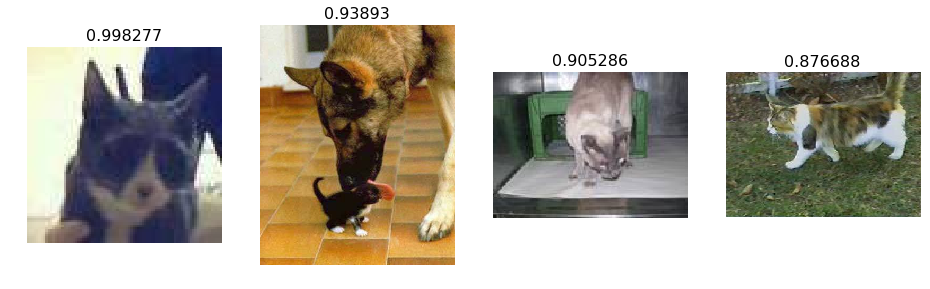

In [10]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


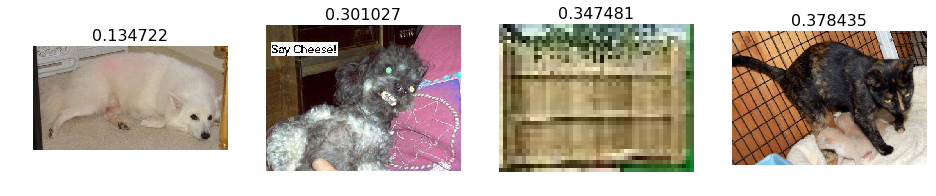

In [11]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")


---

---


In [1]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

PATH = "data/dogscats/"
sz = 299
ARCH = resnext50
bs = 8 # if a TitanX is maxing out at 28, I'll give this 870M 8..

In [6]:
tfms = tfms_from_model(ARCH, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=6, num_workers=4, test_name='test1')
learn = ConvLearner.pretrained(ARCH, data, precompute=False, ps=0.5)
learn.load('RNx_224_all_50')

---

See: https://github.com/fastai/fastai/issues/23 and https://github.com/pytorch/pytorch/issues/973

Something about max open file descriptors (fds) -- maybe bc new Archs in fastai make new files instead of folders? Anyway, to avoid the error 2 lines down: specify `!ulimit -n 2048` or so. Hopefully a more permanent solution is available soon. Also the fix only seems to work in the terminal, before starting the Jupyter session.

In [12]:
!ulimit -n

1024


In [7]:
log_preds = learn.TTA(is_test=True)

RuntimeError: received 0 items of ancdata

---

---

In [4]:
!ulimit -n

1024


In [2]:
# Python fix to ulimit issue above: https://github.com/fastai/fastai/issues/23#issuecomment-345091054
import resource
rlimit = resource.getrlimit(resource.RLIMIT_NOFILE)
print(f'getrlimit before:{resource.getrlimit(resource.RLIMIT_NOFILE)}')
resource.setrlimit(resource.RLIMIT_NOFILE, (4096, rlimit[1]))
print(f'getrlimit after:{resource.getrlimit(resource.RLIMIT_NOFILE)}')

getrlimit before:(1024, 1048576)
getrlimit after:(4096, 1048576)


In [3]:
# checking:
!ulimit -n

4096


#### << Reload everything and run .TTA() again >>

In [1]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

PATH = "data/dogscats/"
sz = 299
ARCH = resnext50
bs = 8 # if a TitanX is maxing out at 28, I'll give this 870M 8..

tfms = tfms_from_model(ARCH, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=6, num_workers=4, test_name='test1')
learn = ConvLearner.pretrained(ARCH, data, precompute=False, ps=0.5)
learn.load('RNx_224_all_50')

In [4]:
log_preds = learn.TTA(is_test=True)

ValueError: feather only support IO with DataFrames

---

#### Saving Predictions

In [11]:
# forgot that TTA() returns 2 things
log_preds = log_preds[0]

In [13]:
df = pd.DataFrame(log_preds)

In [21]:
df.head()

,0,1
0,-9.827118,-0.000062
1,-7.464314,-0.000654
2,-13.206347,-0.000003
3,-13.096326,-0.000002
4,-8.735059,-0.000163


In [22]:
data.classes

['cats', 'dogs']

In [27]:
df.columns = data.classes

In [30]:
df['dogs'][:10]

0   -0.000062
1   -0.000654
2   -0.000003
3   -0.000002
4   -0.000163
5   -6.392356
6   -5.821492
7   -0.000551
8   -4.589474
9   -0.010866
Name: dogs, dtype: float32

Looks good. Need to have type(str) columns for the DataFrame otherwise Pandas won't save it as a `.feather`.

In [60]:
# making sure I don't waste 15 minutes by losing predictions to an ssh broken pipe again
pd.DataFrame.to_feather(df, PATH+'results/'+'RNx_225_all_50_logpreds.feather')

---

#### Submission

Submission format is `id,label`, with `label` being the predicted likelihood of being a dog. `data.classes` shows that 'dogs' is the 2nd category, so save the 2nd column of predictions to the submission file. Also the LogLoss eval metric judges strongly against total wrong answers (`1` or `0` when the answer is NOT `1` or `0`), so the predictions will be clipped to `[0.05:0.95]` as that gives better results.

In [32]:
test_preds = np.exp(log_preds)

In [33]:
data.test_dl.dataset.fnames[:10]

['test1/9323.jpg',
 'test1/10291.jpg',
 'test1/7641.jpg',
 'test1/10707.jpg',
 'test1/9769.jpg',
 'test1/4283.jpg',
 'test1/9966.jpg',
 'test1/6870.jpg',
 'test1/6680.jpg',
 'test1/744.jpg']

In [34]:
learn.data.test_dl.dataset.fnames[:10]

['test1/9323.jpg',
 'test1/10291.jpg',
 'test1/7641.jpg',
 'test1/10707.jpg',
 'test1/9769.jpg',
 'test1/4283.jpg',
 'test1/9966.jpg',
 'test1/6870.jpg',
 'test1/6680.jpg',
 'test1/744.jpg']

In [38]:
preds = np.clip(test_preds[:,1], 0.05, 0.95)
ids   = [i[6:-4] for i in learn.data.test_dl.dataset.fnames]
submission = pd.DataFrame({'id':ids, 'label':preds})

In [46]:
SUBM = 'subm/'
submission.to_csv(PATH+SUBM+'submission_RNx_224_all_50.csv.gz', compression='gzip', index=False)
FileLink(PATH+SUBM+'submission_RNx_224_all_50.csv.gz')

/home/wnixalo/Kaukasos/FADL1/data/dogscats/subm/submission_RNx_224_all_50.csv.gz

In [61]:
temp = pd.read_feather(PATH+'results/'+'RNx_225_all_50_logpreds.feather')

In [62]:
temp['cats'][0]

-9.8271179

In [63]:
log_preds[:,0][0]

-9.8271179

Good, so there's no loss of data when saving as a DataFrame.

---

This model got `0.08151` on the Kaggle Dogs vs Cats Redux competition. Tied for 266/1314.

---

### Testing FDs Issue 

https://github.com/fastai/fastai/issues/23#issuecomment-345412558

#### THIS TESTING SECTION:

fastai library updated to use loops instead of list comprehension to fix max-open file-descriptors issue -- conda-installed PyTorch uninstalled and replaced w/ source-installs.

In [1]:
!ulimit -n

1024


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

PATH = "data/dogscats/"
sz = 299
ARCH = resnext50
bs = 8

tfms = tfms_from_model(ARCH, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=6, num_workers=4, test_name='test1')
learn = ConvLearner.pretrained(ARCH, data, ps=0.5, precompute=False)

In [3]:
learn.load('RNx_224_all_50')

In [4]:
log_preds = learn.TTA(is_test=True)[0]

In [7]:
log_preds.shape

(12500, 2)

---

Previous testing below:

In [4]:
log_preds = learn.TTA(is_test=True)[0]

RuntimeError: received 0 items of ancdata

---


---

---

In [4]:
learn = ConvLearner.pretrained(ARCH, data, ps=0.5, precompute=False)

TypeError: __init__() takes 1 positional argument but 2 were given

In [ ]:
learn.load('RNx_224_all_50')

In [ ]:
log_preds = learn.TTA(is_test=True)